# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.20849999533966185


When finished, you can close the environment.

### 4. Building the DDPG model
First we specifiy our hyper-parameters that we will use in this project. 
Then we build the neural networks that will act as the actor and critic models

In [6]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

# hyper-parameter definitions:
HIDDEN_LAYERS = [400, 300] # Hidden layer sizes of the actor and critic networks

LR_A = 1e-4              # learning rate for the actor
LR_C = 1e-3              # learning rate for the critic
DISCOUNT_RATE = 0.99     # discount factor
TAU = 1e-3               # soft update factor
BUFFER_SIZE = int(1e6)   # buffer size for replay buffer
BATCH_SIZE = 128         # batch size
WEIGHT_DECAY = 0.0       # L2 weight decay
NOISE_INITIAL = 1.0      # Initial noise factor
NOISE_DECAY = 0.999999   # Noise factor
NOISE_MIN = 0.0          # Minimum noise factor
T_UPDATE = 20            # Number of timesteps between updating the target network
NUM_UPDATES = 10         # Amount of times to update the network every T_UPDATE timesteps


EPS_MAX = 2000           # Number of max episodes to train to TARGET_MEAN_SCORE
T_MAX = 1000             # Number of max timesteps per episode
TARGET_MEAN_SCORE = 30.0 # target score for the enviroment for 'success'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We specify the actor and critic networks

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """ Actor(policy) model """
    def __init__(self, state_size, action_size, seed, layers):
        """Initialize parameters for model
        Parameters:
            state_size (int): dimensions of the state space
            action_size (int): dimensions of the action space
            seed (int): random seed
            layers (int list): size of the hidden layers
        """
        super(Actor, self).__init__()
        torch.seed = torch.manual_seed(seed)
        
        self.bns = nn.ModuleList([nn.BatchNorm1d(t) for t in layers])
        
        layers = [state_size] + layers + [action_size]
        self.layers = nn.ModuleList([nn.Linear(fst, snd) for (fst, snd) in zip(layers[:-1], layers[1:])])
        
        self.reset_parameters()
        
    def reset_parameters(self):
        """ Set initial weights """
        for layer in self.layers[:-1]:
            layer.weight.data.uniform_(*hidden_init(layer))
        self.layers[-1].weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state):
        """
        Builds an actor(policy) network that maps state to actions
        """
        x = F.relu(self.bns[0](self.layers[0](state)))
        for (layer, norm) in zip(self.layers[1:-1], self.bns[1:]):
        #for layer in self.layers[1:-1]:
            x = layer(x)
            x = norm(x)
            x = F.relu(x)
        return F.tanh(self.layers[-1](x))
    
class Critic(nn.Module):
    """ Critic(value) network """
    def __init__(self, state_size, action_size, seed, layers):
        """Initialize parameters for model
        Parameter:
            state_size (int): dimensions of the state space
            action_size (int): dimensions of the action space
            seed (int): random seed
            layers (int list): size of the hidden layers
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        # ensure that we have atleast 1 hidden layer for action to come after state in the network
        assert len(layers) >= 1
        
        self.bns = nn.ModuleList([nn.BatchNorm1d(t) for t in layers])
        
        self.layers = nn.ModuleList([nn.Linear(state_size, layers[0])])
        layers = layers + [1]
        layers[0] += action_size
        self.layers.extend([nn.Linear(fst, snd) for (fst, snd) in zip(layers[:-1], layers[1:])])
        
        self.reset_parameters()
        
    def reset_parameters(self):
        """ Set initial weights """
        for layer in self.layers[:-1]:
            layer.weight.data.uniform_(*hidden_init(layer))
        self.layers[-1].weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        """
        Builds an critic(value) network that maps state and actions to their value
        """
        x = F.relu(self.bns[0](self.layers[0](state)))
        # we concat here to attach the actions to the output of the first hidden layer
        x = torch.cat((x, action), dim=1)
        for (layer, norm) in zip(self.layers[1:-1], self.bns[1:]):
            x = layer(x)
            x = norm(x)
            x = F.relu(x)
        return self.layers[-1](x)

Defining the DDPG agent that will be trained using experience replay and soft updates on target networks

In [8]:
class Agent():
    """Interacts with and learns from the enviroment"""
    
    def __init__(self, num_agents, state_size, action_size, random_seed):
        """Initialize an agent
        Parameters:
            state_size (int): dimensions of state space
            action_size (int): dimension of action space
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        
        # Actor networks with local and target
        self.actor_local = Actor(state_size, action_size, random_seed, HIDDEN_LAYERS).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed, HIDDEN_LAYERS).to(device)
        self.actor_optim = optim.Adam(self.actor_local.parameters(), lr=LR_A)
        
        # Critic networks with local and target
        self.critic_local = Critic(state_size, action_size, random_seed, HIDDEN_LAYERS).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed, HIDDEN_LAYERS).to(device)
        self.critic_optim = optim.Adam(self.critic_local.parameters(), lr=LR_C)
        
        # Noise process
        self.noise = OUNoise(num_agents, action_size, random_seed)
        self.noise_factor = NOISE_INITIAL
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
    def step(self, timestep, state, action, reward, next_state, done):
        # Save experiences in replay memory and use random sampling from buffer to learn
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and timestep % T_UPDATE == 0:
            for _ in range(NUM_UPDATES):
                experiences = self.memory.sample()
                self.learn(experiences, DISCOUNT_RATE)
            
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy"""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        
        if add_noise:
            action += self.noise.sample() * self.noise_factor
            #self.noise_factor = max(self.noise_factor * NOISE_DECAY, NOISE_MIN)
        return np.clip(action, -1, 1)
    
    def reset(self):
        """ Reset learning behavior episodically """
        self.noise.reset()
        
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples:
        Q_target = r + gamma * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Parameters:
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount rate
        """
        states, actions, rewards, next_states, dones = experiences
        
        # Update critic
        # Get predicted next-(state and actions) and Q-values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q-targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optim.zero_grad()
        critic_loss.backward()
        # prevent gradient explosion by gradient clipping
        clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optim.step()
        
        # Update Actor
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()
        
        # Update target network
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        
        # Update noise
        self.noise_factor = max(self.noise_factor * NOISE_DECAY, NOISE_MIN)
        self.noise.reset()
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update target model to local model by tau
        theta_target = tau * theta_local + (1 - tau) * theta_target
        Parameters:
            local_model : PyTorch model (weights will be copied from)
            target_model : PyTorch model (weights will be copied to)
            tau (float): interpolation factor
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)
    
    def model_eval(self):
        self.actor_local.eval()
        self.critic_local.eval()
        
    def model_train(self):
        self.actor_local.train()
        self.critic_local.train()

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, num_agents, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = (num_agents, size)
        self.mu = mu * np.ones(self.size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

We train our networks using this trainer

In [9]:
def train(agents):
    """ Training an DDPG model 
    Parameters:
        agents (Agents): Collection of agents to train DDPG
    """
    # setup record of mean scores per episode keeping complete record
    scores_total = []
    scores_ma = deque(maxlen=100)
    # setup time_stamp to periodically update target models
    time_stamp = 0
    # setup model to train
    agents.model_train()
    
    # loop over all episodes or until having learned sufficiently
    for i in range(1, EPS_MAX + 1):
        # get enviroment info
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        # reset internal learning behavior episodically
        agents.reset()
        # keep record of the score of each agent over all timesteps
        scores = np.zeros(num_agents)
        
        # have the agents act and train in the enviroment until max timesteps per episode of any agent finishes
        for t in range(1, T_MAX + 1):
            # get actions from agents for current state
            actions = agents.act(states)
            # get current enviroment based on current actions
            env_info = env.step(actions)[brain_name]
            # get rewards, next_states, and dones of all agents
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done
            
            # send all relevant info to agents to train model
            for s, a, r, ns, d in zip(states, actions, rewards, next_states, dones):
                agents.step(time_stamp, s, a, r, ns, d)
                
            # update current states and scores
            states = next_states
            scores += rewards
            # update time_stamp
            time_stamp += 1
            # if any agent is done, exit current episode
            if np.any(dones):
                break
                
        # update history of episodic scores
        scores_mean = np.mean(scores)
        scores_total.append(scores_mean)
        scores_ma.append(scores_mean)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tAverage 100 moving average Score: {:.2f}'.format(i, scores_mean, np.mean(scores_ma)), end="")
        if i % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tAverage 100 moving average Score: {:.2f}'.format(i, scores_mean, np.mean(scores_ma)))
        if np.mean(np.mean(scores_ma)) >= TARGET_MEAN_SCORE:
            print('\nEnvironment solved in {:d} episodes!\tAverage 100 moving average Score: {:.2f}'.format(i, np.mean(scores_ma)))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores_total

Creating the agents to train and training them

In [10]:
agents = Agent(num_agents, state_size, action_size, 0)
scores = train(agents)

Episode 10	Average Score: 31.05	Average 100 moving average Score: 25.68
Episode 20	Average Score: 33.95	Average 100 moving average Score: 29.30
Episode 25	Average Score: 33.37	Average 100 moving average Score: 30.13
Environment solved in 25 episodes!	Average 100 moving average Score: 30.13


Displaying a graph of the training process

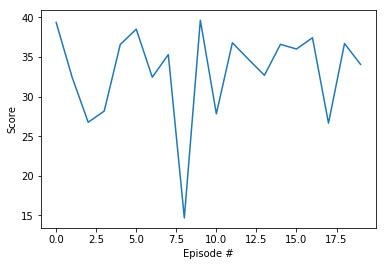

In [14]:
import matplotlib.pyplot as plt

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Testing the trained agent

In [12]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
agents.model_eval()                                    # set model to evaluation
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agents.act(states, False)                # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 33.1694992586039


In [13]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 